# Machine Learning Project: Neural Networks

This project follows our previous series of projects on Machine Learning.

First of all, we create a cell for all the libraries we will need to import for our project. We will use NumPy for linear algebra & complex operations over arrays, Matplotlib for displaying 2D plots, the Python Image Library (PIL) for importing custom images, Tensorflow for comparing our implementation to the library's implementation, the csv library to help retrieve data from CSV files and the typing library, to define type hints in function definitions, for documentation purposes. 

In [1]:
import time
import random

import math

from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Sequential
import tensorflow as tf

import csv
from typing import NoReturn, List, Union, Tuple

We set some parameters to increase the height of Matplotlib figures and change NumPy print option so all outputs can be displayed properly in the notebook.

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20
np.set_printoptions(precision=5, suppress=True)

This time around, we will not plot weights and biases directly compared to input data; however, we can plot our models weights using heatmaps that might reveal how the neural networks "perceives" shapes and abstracts the inputs into subclasses, before outputing predictions.

In [3]:
MAX_PER_LINE = 10
def display_weights(weights_array, image_shape, bias, layer_name):
    fig, axs = plt.subplots(math.ceil(len(weights_array)/MAX_PER_LINE), MAX_PER_LINE)
    for i, neuron in enumerate(weights_array):
        axs[i//MAX_PER_LINE][i%MAX_PER_LINE].imshow(neuron[bias:].reshape(image_shape).astype(np.float64), cmap="gray")
        axs[i//MAX_PER_LINE][i%MAX_PER_LINE].set_title("Neuron #" + str(i))

    fig.suptitle("Weights of '" + layer_name + "' Layer", fontsize=20)
    fig.tight_layout(pad=2.0)

# Computer Vision (Deep Learning) Example: Supervised Digit Recognition Based on Image Data

The dataset can found in the project folder (features.csv + labels.csv) and has probably been extracted from one of the NIST datasets; however, today, the MNIST datasets are more commonly used (http://yann.lecun.com/exdb/mnist/).

We start by implementing a function to load the image data into an array containing (observation, label) couples.

Total: 5000 images
Example digit: 4 (image #2180)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


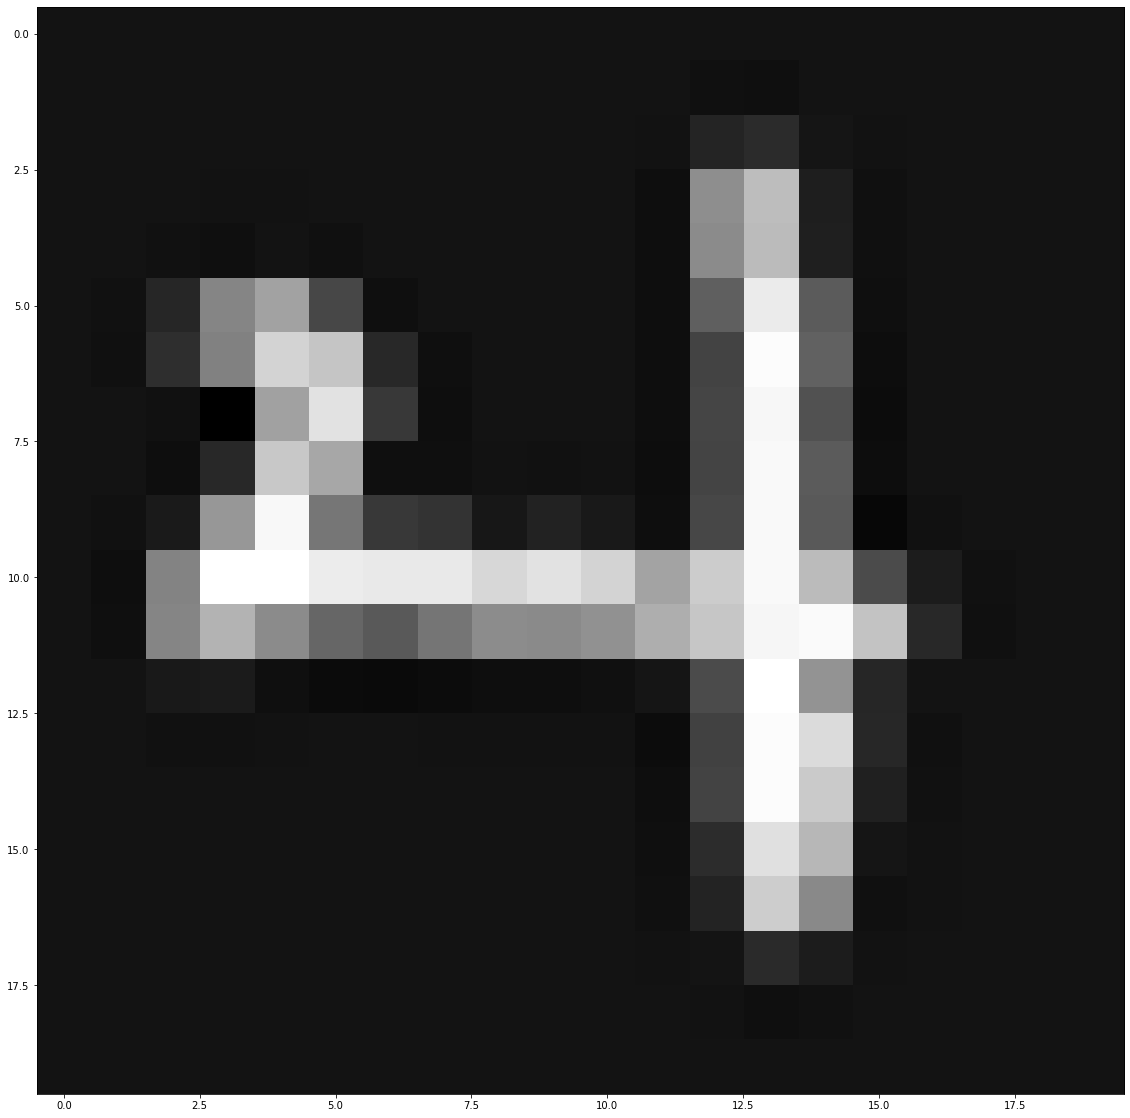

In [4]:
def import_image_data(features_path, labels_path, n_classes):
    csv_file_rows = open("features.csv")
    csv_file_labels = open("labels.csv")

    reader = csv.reader(csv_file_rows, delimiter=',')
    reader_labels = csv.reader(csv_file_labels, delimiter=',')

    images = []
    for row in reader:
        row = np.array(row, dtype=np.float64).reshape(20, 20).T   # We use the transpose because the lines are encoded column-first
        images.append([row])

    i=0
    for label in reader_labels:
        one_hot = np.zeros(n_classes)
        n = int(label[0])
        n = n*(n!=10)                                             # Zeros are labelled as "10", so we create a special case to label them back to 0
        one_hot[n] = 1
        images[i].append(one_hot)                                 # The one hot encoded vector is appended to the list now containing only the row
        i+=1


    print("Total:", i, "images")

    images = np.array(images, dtype=object)
    idx = np.random.randint(0, len(images))
    plt.imshow(images[idx, 0], cmap="gray")
    print("Example digit:", np.argwhere(images[idx, 1])[0][0], "(image #" + str(idx) + ")")
    print(images[idx, 1])

    return images

images = import_image_data("features.txt", "labels.txt", 10)

As we can see, the data comes from one of the NIST datasets (which contains images of handwritten digits, i.e. digits 0 to 9, of size 20x20 pixels).

We will start implementing the logic of our neural network engine. To start with we implement our activation and cost functions, with a class logic similar to that of Java, storing the functions in static methods of classes of abstract classes:

In [5]:
class Functions:
    """
    The class containing numerical functions used in a neural network Model

    (The class is completely static)
    """

    class Cost:
        """
        The class containing cost functions used by a neural network OutputLayer

        The cost functions calculate the cost of the model based on the activations of
        the output layer and the expected values

        Just like in linear/logistic regressions, they allow for gradient descent and
        estimating how close to the expected values are the predictions of the FFNN

        (The class is completely static)
        """

        @staticmethod
        def log_loss(output: np.ndarray, expected: np.ndarray, derivative: bool = False) -> np.ndarray:
            """
            The logistic cost/loss function ( - expected * log(output) ) if derivative is False, or the derivative of
            the logistic cost/loss function ( - expected / output ) if derivative is True

            :param output: The activation of the neurons of the OutputLayer

            :param expected: The expected outputs for the given data inputs last fed to the neural network Model

            :param derivative: Whether the result should be the result of the function or of the derivative of the
            function. Default value: False

            :return: The output Numpy array of floats
            """
            if output.shape != expected.shape:
                raise Exception("The dimensions of the output " + str(
                    output.shape) + " mismatch the dimensions of the expected values " + str(expected.shape) + ".")

            if derivative:
                return - expected / output
            else:
                return - expected * np.log(output)

        default = log_loss

    class Activation:
        """
        The class containing activation functions used by a neural network Layer

        The activation functions are applied to the outputs of a given layer before being passed on to the next; they
        usually regularise the output between 0 and 1 or 1 and -1 (in the case of sigmoids), or simply ignore negative
        output (in the cases of rectifiers)

        They should be equivalent to δJ/δH_l_output = δJ/δσ_output × δσ_output/δH_output, with l_output the output
        layer, the penultimate layer, H the hypothesis function (matrix multiplication of W_layer and σ_previous_layer)
        and σ the activation function

        The softmax function is usually used to normalize the activations of the output layer

        (The class is completely static)
        """

        @staticmethod
        def logistic_sigmoid(x: Union[np.ndarray, float], derivative: bool = False) -> Union[np.ndarray, float]:
            """
            Returns the logistic sigmoid of x ( 1/1+e^x ) if derivative is False, or the derivative of the logistic
            sigmoid of x if derivative is True ( e^x * (1+e^x)² )

            :param x: The input float or Numpy array

            :param derivative: Whether the result should be the result of the function or of the derivative of the
            function. Default value: False

            :return: The output float or Numpy array of floats
            """
            exp = np.exp(-x)
            if derivative:
                return exp / ((exp + 1) ** 2)
            else:
                return 1 / (1 + exp)

        @staticmethod
        def softmax(x: np.ndarray, derivative: bool = False) -> np.ndarray:
            """
            Returns the softmax activation of x ( e^(x-max(x)) / Σ (e^(x-max(x))) ) if derivative is False, or the
            derivative of the logistic sigmoid of x if derivative is True
            ( e^(x-max(x))/ Σ (e^(x-max(x))) * (1 - e^(x-max(x)) / e^(x-max(x))/ Σ (e^(x-max(x))) ) )

            :param x: The input float or Numpy array (expects an array as the softmax of a single value is always 1)

            :param derivative: Whether the result should be the result of the function or of the derivative of the
            function. Default value: False

            :return: The output Numpy array of floats
            """
            exp = np.exp(x - x.max())
            if derivative:
                sum_exp = np.sum(exp, axis=0)
                return exp / sum_exp * (1 - exp / sum_exp)
            else:
                return exp / np.sum(exp, axis=0)

        default = logistic_sigmoid

    class Delta:
        """
        The class containing delta functions used by a neural network OutputLayer

        "Delta functions" simplify calculations of the output layer's 𝛿 to one function

        They should be equivalent to δJ/δH_l_output = δJ/δσ_output × δσ_output/δH_output,
        with l_output the output layer, the penultimate layer, H the hypothesis function
        (W_layer @ σ_previous_layer) and σ the activation function

        (The class is completely static)
        """

        @staticmethod
        def log_loss_softmax(output: np.ndarray, expected: np.ndarray) -> np.ndarray:
            """
            The "delta function" for a log loss cost function and a softmax activation function.
            Returns output - expected

            :param output: The output activation of the OutputLayer

            :param expected: The expected outputs for the given data inputs last fed to the neural network Model

            :return: The return Numpy array of floats
            """
            if output.shape != expected.shape:
                raise Exception("The dimensions of the output " + str(
                    output.shape) + " mismatch the dimensions of the expected values " + str(expected.shape) + ".")

            return output - expected

        default = log_loss_softmax

We also implement functions to initialise the weight matrix for each layers. `initialise_weight_array` takes an array shape, a weight initialiser and a layer reference to generate each weight depending on the function.

In [6]:
class Layer:
    pass


class Weights:
    """
    The class containing weight functions for a neural network Model

    (The class is completely static)
    """

    @staticmethod
    def initialise_weight_array(n: int, m: int, func: callable, layer: Layer) -> np.ndarray:
        """
        The function used to initialise the weight matrix of a given Layer with a weight-initialising function

        :param n: Number of lines (neurons) of the weight matrix
        
        :param m: Number of weights (including a potential bias) per neuron in the weight matrix (number of columns of 
        the matrix)
        
        :param func: The weight-initialising function used to generate each weight of the weight matrix (as a function
        of the line number, the column number and the layer instance)
        
        :param layer: The layer instance used by the weight initialiser
        
        :return: The filled weight matrix (a numpy float array)
        """
        arr = np.zeros((n, m))
        for i in range(n):
            for j in range(m):
                arr[i, j] = func(n, m, layer)

        return np.array(arr, dtype=np.float64)

    class Initialiser:
        """
        The class containing functions for initialising the weights of a neural network Layer

        (The class is completely static)
        """

        @staticmethod
        def zero(neuronid_: int, weightid_: int, layer: Layer) -> float:
            """
            Returns 0.0

            :param neuronid_: The position of the neuron in the Model weight matrix for a given Layer

            :param weightid_: The position of the weight for the neuron #"neuronid_", in the Model weight matrix for
            a given Layer

            :param layer: The Layer for which the weights are generated

            :return: The weight value generated for the given Layer, neuron and weight in its corresponding weight
            matrix
            """
            return 0.0

        @staticmethod
        def rand_one(neuronid_: int, weightid_: int, layer: Layer) -> float:
            """
            Returns a random float between -1 and 1

            :param neuronid_: The position of the neuron in the Model weight matrix for a given Layer

            :param weightid_: The position of the weight for the neuron #"neuronid_", in the Model weight matrix for
            a given Layer

            :param layer: The Layer for which the weights are generated

            :return: The weight value generated for the given Layer, neuron and weight in its corresponding weight
            matrix
            """
            return 2 * (random.random() - 0.5)

        @staticmethod
        def rand_ten(neuronid_: int, weightid_: int, layer: Layer) -> float:
            """
            Returns a random float between -10 and 10

            :param neuronid_: The position of the neuron in the Model weight matrix for a given Layer

            :param weightid_: The position of the weight for the neuron #"neuronid_", in the Model weight matrix for
            a given Layer

            :param layer: The Layer for which the weights are generated

            :return: The weight value generated for the given Layer, neuron and weight in its corresponding weight
            matrix
            """
            return 20 * (random.random() - 0.5)

        @staticmethod
        def sqrt_layer_size(neuronid_: int, weightid_: int, layer: Layer) -> float:
            """
            Returns a random float between -1 * √ (1/layer.n_neurons) and 1 * √ (1/layer.n_neurons) with
            layer.n_neurons the number of output neurons of the Layer layer.

            :param neuronid_: The position of the neuron in the Model weight matrix for a given Layer

            :param weightid_: The position of the weight for the neuron #"neuronid_", in the Model weight matrix for
            a given Layer

            :param layer: The Layer for which the weights are generated

            :return: The weight value generated for the given Layer, neuron and weight in its corresponding weight
            matrix
            """
            return Weights.Initialiser.rand_one() * np.sqrt(1.0 / layer.n_neurons)

        default = rand_one


Now for feed-forward neural network architecture, we will use a `Model` class to initialise the neural networks, to keep in memory all of its parameters (weights, activations, hypotheses, deltas...) and to do the feedforward and gradient descent calculations.

The `Layer` classes will only keep some layer/neuron-specific parameters such as the learning rates, the functions determining the way weights are initialised, whether the layer uses a bias or not, the number of inputs/outputs and the type of the layer.

We implement 3 main types of layers, `FlattenLayer`, which will serve as the class for input layers (flattens and returns the input), `DenseLayer` which will serve as the class for hidden layers (containing a layer-specific activation function, layer or neuron-specific learning rates, a predefined number of output neurons, and a weight initialiser), and `OutputLayer`, which much like the dense layers initialises its weights with the `Model`, but also contains a cost function in addition to the activation functions.

In [7]:
class Layer:
    """
    The base class for a Layer of a feedforward neural network Model; contains layer-specific attributes

    Example::
        unspecified_layer = Layer( 100, ( lambda x, derivative=False: x * (x > 0) if not derivative else
                                         x - x + 1 * (x > 0) ),
                                  True, np.zeros(100) + 0.1, ( lambda neuronid_, weightid_, layer: 0.0 ), "layer" )
    """

    def __init__(self, n_neurons: int, activation_function: callable = Functions.Activation.logistic_sigmoid,
                 use_bias: bool = True, learning_rate: Union[np.ndarray, float] = 0.01,
                 weight_initialiser: callable = Weights.Initialiser.default, type_: str = "layer") -> NoReturn:
        """
        Layer class constructor

        :param n_neurons: The number of output neurons in the layer

        :param activation_function: The activation function (act) of the Layer; must accept a boolean argument
                                    called derivative, such that the function will return the derivative of the
                                    activation function if derivative is True, or simply return the activation if
                                    derivative is False; the returned value must be a numpy array of floats.
                                    Default value: Functions.Activation.logistic_sigmoid

        :param use_bias: Whether the layer should use a bias or not. Default value: True

        :param learning_rate: The value of the layer-specific learning rate (alpha); can be a numpy array specifying
                              neuron-specific learning. Learning rates should usually be between 0.001 and 1.
                              Default value: 0.01

        :param weight_initialiser: The function used for initialising the layer weights, as a function of the id of the
                                   neuron in layer, the id of the weight of the neuron (i.e. to which input it is
                                   linked), and the layer instance; must accept the three argument (neuron number,
                                   weight number, layer instance), and return a numpy array of floats.
                                   Default value: Weights.Initialiser.default

        :param type_: A string indicating the type of the Layer (layer, input, output or dense). Default value: "layer"
        """
        self.id_ = None  #: The identifier of the Layer within a Model instance
        self.type_ = type_  #: A simple label that should indicate the type of the layer

        self.act = activation_function  #: The activation functions used by the layer's neurons
        self.alpha = learning_rate  #: The learning rate (neuron-specific if an array or layer-specific if a float)

        self.n_outputs = n_neurons  #: The number of output neurons for the layer instance. Same as n_neurons
        self.n_neurons = n_neurons  #: The number of output neurons for the layer instance. Same as n_outputs
        self.n_inputs = None  # : The number of input neurons each neuron of the layer is linked too. None by
        # default, initialised with a Model or initialised when instantiating an input layer

        if self.type_ == "output":
            self.n_classes = n_neurons  #: The number of output classes for an OutputLayer. Same as n_neurons, n_outputs

        self.use_bias = use_bias  #: A boolean indicating whether the layer uses a bias or not. Used for initialising
        # the weight matrix (which should be of shape (n_neurons, n_inputs + use_bias)), for ignoring the first weight
        # when carrying out backpropagation, and adding a one in front of the inputs when carrying out a feedforward

        self.w_init = weight_initialiser  #: The weight initialiser used by a Model instance to create the weight matrix
        # associated with the Layer instance


class FlattenLayer(Layer):
    """
    The class used for the input layer of a feedforward neural network Model. Flattens the input to a given array
    of shape (n_inputs,)

    Example::
        input_layer = FlattenLayer( 100 )
    """

    def __init__(self, n_inputs: int) -> NoReturn:
        """
        FlattenLayer class constructor

        :param n_inputs: The number of single neuron inputs for the next layer of the feedforward neural network Model
        """
        super().__init__(n_inputs, activation_function=None, use_bias=False, learning_rate=None,
                         weight_initialiser=None, type_="input")
        self.n_inputs = n_inputs  #: The number of input neurons for the input layer (same number as output neurons)

    def out(self, X: np.ndarray) -> np.ndarray:
        """
        The outputs of the input layer

        :param X: input numpy array/image

        :return: flattened output of shape (n_inputs,)
        """
        X = X.flatten()
        if len(X) != self.n_inputs:  # Raise an error if the input array cannot be flattened to the desired shape
            raise Exception("Input dimensions " + str(
                X.shape()) + " mismatch excepted dimensions (" + self.n_inputs + ",).")

        return X


class DenseLayer(Layer):
    """
    The class used for the dense layer of a feedforward neural network Model. Contains layer-specific attributes,
    except the weights and outputs of the layer, that are instead handled by the Model class.

    Example::
        dense_layer = DenseLayer( 100, ( lambda x, derivative=False: return x * (x > 0) if not derivative else
                                         x - x + 1 * (x > 0) ),
                                  True, 0.1, ( lambda neuronid_, weightid_, layer: 0.0 ) )
    """

    def __init__(self, n_neurons: int, activation_function: callable = Functions.Activation.logistic_sigmoid,
                 use_bias: bool = True, learning_rate: Union[np.ndarray, float] = 0.01,
                 weight_initialiser: callable = Weights.Initialiser.default) -> NoReturn:
        """
        DenseLayer class constructor

        :param n_neurons: The number of output neurons in the layer

        :param activation_function: The activation function (act) of the Layer; must accept a boolean argument
                                    called derivative, such that the function will return the derivative of the
                                    activation function if derivative is True, or simply return the activation if
                                    derivative is False; the returned value must be a numpy array of floats.
                                    Default value: Functions.Activation.logistic_sigmoid

        :param use_bias: Whether the layer should use a bias or not. Default value: True

        :param learning_rate: The value of the layer-specific learning rate (alpha); can be a numpy array specifying
                              neuron-specific learning. Learning rates should usually be between 0.001 and 1.
                              Default value: 0.01

        :param weight_initialiser: The function used for initialising the layer weights, as a function of the id of the
                                   neuron in layer, the id of the weight of the neuron (i.e. to which input it is
                                   linked), and the layer instance; must accept the three argument (neuron number,
                                   weight number, layer instance), and return a numpy array of floats.
                                   Default value: Weights.Initialiser.default
        """
        super().__init__(n_neurons, activation_function, use_bias, learning_rate, weight_initialiser, type_="dense")


class OutputLayer(Layer):
    """
    The class used for the dense layer of a feedforward neural network Model. Contains layer-specific attributes,
    except the weights and outputs of the layer, that are instead handled by the Model class.

    Example::
        output_layer = OutputLayer( 10, ( lambda x, derivative=False: x * (x > 0) if not derivative else
                                          x - x + 1 * (x > 0) ),
                                    ( lambda output, expected, derivative=False: - expected * np.log(output) if
                                      not derivative else - expected / output ), ( lambda output, expected:
                                      output - expected  ), True, 0.1, ( lambda neuronid_, weightid_, layer: 0.0 ) )
    """

    def __init__(self, n_neurons: int, activation_function: callable = Functions.Activation.logistic_sigmoid,
                 cost_function: callable = Functions.Cost.log_loss, gradient_of_cost_and_activation: callable = None,
                 use_bias: bool = True, learning_rate: Union[np.ndarray, float] = 0.01,
                 weight_initialiser: callable = Weights.Initialiser.default) -> NoReturn:
        """
        The OutputLayer class constructor

        :param n_neurons: The number of output neurons in the layer

        :param activation_function: The activation function (act) of the Layer; must accept a boolean argument
                                    called derivative, such that the function will return the derivative of the
                                    activation function if derivative is True, or simply return the activation if
                                    derivative is False; the returned value must be a numpy array of floats.
                                    Default value: Functions.Activation.logistic_sigmoid

        :param cost_function: The cost/loss function (cost) of the Layer; must accept a boolean argument
                              called derivative, such that the function will return the derivative of the cost/loss
                              function if derivative is True, or simply return the cost/loss if derivative is False;
                              the returned value must be a numpy array of floats.
                              Default value: Functions.Activation.logistic_sigmoid

        :param gradient_of_cost_and_activation: A special function (delta) to simplify calculations of an OutputLayer δ.
                                                The function should be equal to δcost_function/δactivation_function *
                                                δactivation_function/δoutput_hypothesis, with output_hypothesis being
                                                the hypothesis of the OutputLayer. Must return a numpy array of floats.
                                                If None, the OutputLayer δ is calculated using the derivatives of the
                                                cost_function and activation_function functions. Default value: None

        :param use_bias: Whether the layer should use a bias or not. Default value: True

        :param learning_rate: The value of the layer-specific learning rate (alpha); can be a numpy array specifying
                              neuron-specific learning. Learning rates should usually be between 0.001 and 1.
                              Default value: 0.01

        :param weight_initialiser: The function used for initialising the layer weights, as a function of the id of the
                                   neuron in layer, the id of the weight of the neuron (i.e. to which input it is
                                   linked), and the layer instance; must accept the three argument (neuron number,
                                   eight number, layer instance), and return a numpy array of floats.
                                   Default value: Weights.Initialiser.default
        """
        super().__init__(n_neurons, activation_function,
                         use_bias, learning_rate, weight_initialiser, type_="output")

        self.cost = cost_function  #: The callable cost function of the OutputLayer
        self.delta = gradient_of_cost_and_activation  #: The callable "delta function" of the OutputLayer (or None)



For our `Model` class, we will implement it step-by-step. First, we implement the class constructor. It takes a list of layers and initialises their weights in the `weights` attribute, which will contain the weight matrices of every layers. It also declares the `outputs` attributes, which will store the outputs (hypotheses, activations & deltas) of every layer. `weights` and `outputs` contain the parameters of the neural network at a given iteration of training (or in-between training).

We also implement a method to divide a dataset into test and train data.

In [8]:
class Model:
    """
    The class used for initialising a neural network Model, making the feedforward and backpropagation operations,
    and training a model over a labelled dataset.

    Example::
        model = Model ( [ input layer(100), DenseLayer(50), OutputLayer(10) ] )
    """

    hyp = "H(X, W)"
    "The label used as the key in the 'outputs' parameters for the hypotheses"

    act = "σ(H(X, W))"
    "The label used as the key in the 'outputs' parameters for the activations"

    delta = "𝛿(σ(H(X, W)), expected)"
    "The label used as the key in the 'outputs' parameters for the delta values"

    w = "W"
    "The label used as the key in the 'weights' parameters for the weights values"

    grad = "δJ(𝛿(σ(H(X, W)), expected))/δW"
    "The label used as the key in the 'weights' parameters for the weights gradients"

    total = "Total"
    "The label used as the key in the 'costs' attribute to contain the total cost of an epoch"

    total_ = "Total Per Class"
    "The label used as the key in the 'costs' attribute to contain the total cost per class of an epoch"

    def __init__(self, layers: List[Layer], alpha_decrease_factor: int = 1.1) -> NoReturn:
        """
        The Model class constructor. Initialises the parameters of the Model from the layers given as input

        :param layers: The consecutive layers of the Model instance. The first layer must be of type input layer and
                       the last layer of type OutputLayer
                       
        :param alpha_decrease_factor: If the cost increases between two iterations, lowers learning rates of all
                                      layers of the Model instance by alpha_decrease_factor
        """

        if layers[0].type_ != "input":  # Raise an error if the first layer of the Model isn't an input layer
            raise Exception("Error: The first layer of a Model must be an input layer.")

        if layers[-1].type_ != "output":  # Raise an error if the last layer of the Model isn't an output layer
            raise Exception("Error: The last layer of a Model must be an output layer.")

        self.epochs = None  #: The number of epochs used by the Model for the last training loop
        self.curr_epoch = None  #: The current epochs used of the Model for the current training loop

        self.alpha_decrease_factor = alpha_decrease_factor #: Factor by which to divide excessive learning rates
        
        self.layers = layers  #: Collection of the consecutive layer of the Model instance
        self.layers[0].id_ = 0  # Set the id_ attribute of the first layer to 0 by convention

        for i, layer in enumerate(self.layers[1:], 1):  # For all layers except the input layer
            # Set the number of inputs of a layer to the number of outputs of the previous layer
            layer.n_inputs = self.layers[i - 1].n_neurons
            # Set the _id attribute of other layers by their position in the layers list by convention
            layer.id_ = i

        self.weights = {l: {Model.w: Weights.initialise_weight_array(self.layers[l].n_outputs,
                                                                     self.layers[l].n_inputs + self.layers[l].use_bias,
                                                                     self.layers[l].w_init, self.layers[l]),
                            Model.grad: np.zeros((self.layers[l].n_outputs,
                                                  self.layers[l].n_inputs))} for l in range(1, len(self.layers))}
        """ The attribute containing the weight parameters (weights & weight gradients) of the Model, Layer-by-Layer """

        self.outputs = {l: {Model.hyp: None,
                            Model.act: None,
                            Model.delta: None} for l in range(len(self.layers))}
        """ The attribute containing the output parameters (hypotheses, activations & deltas) of the Model,
            Layer-by-Layer """

        self.costs = {}
        """ An attribute keeping in memory the costs of every epoch """
        
        self.last_weights = {}
        """ An attribute keeping in memory the weights of the last epoch """

        self.curr_training = -1
        """ An identifier of the current training loop of the Model, in case the Model multiple times;
            the default value, -1, signifies that the Model has not yet been trained """

        self.n_outputs = self.layers[-1].n_classes
        """ The number of outputs of the Model, equal to the number of classes of the OutputLayer"""
    
    @staticmethod
    def split_train_test(data: np.ndarray, cutoff_percentage: float) -> Tuple[np.ndarray, np.ndarray]:
        """
        Returns a (train, test) couple split from the data array. The size of the train data is the cutoff percentage of
        the size of the data, and the test is the rest of the data. The data is shuffled before being split.
                
        :param data: The data to split into a train and test dataset

        :param cutoff_percentage: The percentage of the data that will be in the train data
        
        :return: The (train, test) couple split from the data
        """
        data = np.array(data)
        np.random.shuffle(data)

        n_train = int(len(data) * cutoff_percentage)
        train = data[:n_train]
        test = data[n_train:]

        return (train, test)

We now implement the feedforward method of our `Model`. The `feedforward` operation converts an observation input into the corresponding output classes of the model in its current state, by successively multiplying the current input by the next layer's weights, applying the activation function of the next layer, and using the outputs of the next layer as the new input.

In [9]:
def feedforward(self, X: np.ndarray) -> np.ndarray:
    """
    Feeds the input data to the Model, making it go forward through the layers to the final OutputLayer, via
    multiplying the input neurons with a the next Layer's weights, applying the Layer's activation function, and
    repeating the process by taking the outputs of the next Layer as the following Layer's inputs.

    :param X: The input numpy array to be flattened by the input layer, and fed forward in the Model

    :return: The last layer's activation values
    """
    outputs = self.outputs
    weights = self.weights

    # Sets the output activation of the input layer as the flattened input
    outputs[0][Model.act] = self.layers[0].out(X)

    for i, layer in enumerate(self.layers[1:], 1):
        if layer.use_bias:
            # If the layer uses a bias, add a 1 in front of the output activations of the previous layer
            # that will represent the value associated with the bias (the first weight of the layer), and multiply
            # the layer's weight matrix by the activations to get the output hypotheses of the layer
            outputs[i][Model.hyp] = weights[i][Model.w] @ np.concatenate(([1], outputs[i - 1][Model.act]))
        else:
            outputs[i][Model.hyp] = weights[i][Model.w] @ outputs[i - 1][Model.act]

        # Set the activation of the layer to the activation function of the hypotheses of the layer
        outputs[i][Model.act] = layer.act(outputs[i][Model.hyp])

    # Return the last layer's activations
    return outputs[i][Model.act]

Model.feedforward = feedforward

To implement backpropagation, we first need to calculate the weight gradients of our model for its current output. The gradient must be calculated first and applied afterward, as the gradient of a previous layer depends on the weights of the next. We create a `calc_grad` method to calculate the gradient of the current `Model` outputs, after a `feedforward`. The `calc_grad` method will take as input the expected classes for the last observation that has been fed forward. Costs of the model for the current iteration are also calculated and summed in the `costs` attribute.

Backpropagation calculates the derivative of the cost and activation function of the last layer and distributes it on all previous layer by multiplying it by the layers weights and the derivative of the activation function of the target layer, from last to first. Those distributed costs are noted $\delta_l$ (delta). To find the weight gradients of a given layer, the deltas are multiplied by the previous layer's activations (the weight gradient will be proportional to the previous layer's activations, i.e. a large activation that has a large distributed cost will be corrected more than a small activation).

In [10]:
def calc_grad(self, expected: np.ndarray) -> NoReturn:
    """
    Calculates the weight gradients of each layers for the current iterations, and stores them to be applied to the
    weights in the weights Model instance attribute

    :param expected: The expected values for the current iteration
    """
    last = self.layers[-1]  # The last layer
    output = self.outputs[last.id_][Model.act]  # The output activations of the last layer

    outputs = self.outputs
    weights = self.weights

    if last.delta is None:
        # If the last layer has no "delta function", multiply the derivative of the cost function of the output
        # activations and expected value of the current iteration by the derivative of the activation function of
        # the hypothesis of the last layer's hypotheses
        outputs[last.id_][Model.delta] = last.cost(output, expected, derivative=True) \
                                            * last.act(self.outputs[last.id_][Model.hyp], derivative=True)
    else:
        # Otherwise, simply apply the delta function
        outputs[last.id_][Model.delta] = last.delta(output, expected)

    # The cost of every data element are added up in the costs of the Model
    self.costs[self.curr_training][self.curr_epoch][Model.total_] += last.cost(output, expected)
    self.costs[self.curr_training][self.curr_epoch][Model.total] += np.sum(last.cost(output, expected))

    # Sets the gradient of the last layer to the delta of the last layer multiplied by the transpose of the
    # previous layer's activations (i.e. make the gradient proportional to the last layer's activations)
    if last.use_bias:
        # If the layer uses a bias, a one is added in front of the last layer's activation to get a gradient that
        # will include the bias
        weights[last.id_][Model.grad] = outputs[last.id_][Model.delta][:, np.newaxis] @ \
                                        np.concatenate(([1], outputs[last.id_ - 1][Model.act]))[:, np.newaxis].T
    else:
        weights[last.id_][Model.grad] = outputs[last.id_][Model.delta][:, np.newaxis] @ \
                                        outputs[last.id_ - 1][Model.act][:, np.newaxis].T

    # Iterate over the reverse of all layers but the input and output layer
    for i, layer in reversed(list(enumerate(self.layers[1:-1], 1))):
        # To get the delta of every previous layer, the weights of the next layer are multiplied by its delta,
        # and the result is then multiplied by the derivative of the activation function of the current layer's
        # activation
        if self.layers[i + 1].use_bias:
            # If the next layer uses a bias, the operation is applied over all weights excluding the first one (
            # i.e. the bias), as the bias doesn't depend on the current layer's outputs
            outputs[i][Model.delta] = (weights[i + 1][Model.w][:, 1:].T @ outputs[i + 1][Model.delta]) * layer.act(
                outputs[i][Model.hyp], derivative=True)
        else:
            outputs[i][Model.delta] = (weights[i + 1][Model.w].T @ outputs[i + 1][Model.delta]) * layer.act(
                outputs[i][Model.hyp], derivative=True)

        # To get the gradient of every previous layer, the layers' deltas are multiplied by the activations of the
        # previous layer
        if layer.use_bias:
            # If the layer uses a bias, a one is added in front of the last layer's activation to get a gradient
            # that will include the bias
            weights[i][Model.grad] = outputs[i][Model.delta][:, np.newaxis] @ \
                                        np.concatenate(([1], outputs[i - 1][Model.act]))[:, np.newaxis].T
        else:
            weights[i][Model.grad] = outputs[i][Model.delta][:, np.newaxis] @ \
                                        outputs[i - 1][Model.act][:, np.newaxis].T

Model.calc_grad = calc_grad

To apply the gradient, we simply remove the calculated gradients from the weights of each layer in the `weights` attribute with a method (`apply_grad`). One backpropagation operation will simply consist of a gradient calculation followed by the gradients being applied to the weights; we implement it in the `backpropagate` method.

In [11]:
def apply_grad(self):
    """
    Keeps in memory the last layer weight matrices and applies the gradient to the weights (stored as parameters
    to the Model in the weights dict)
    """
    for i, layer in enumerate(self.layers[1:], 1):
        self.last_weights[i] = np.copy(self.weights[i][Model.w])
        self.weights[i][Model.w] -= layer.alpha * self.weights[i][Model.grad]

Model.apply_grad = apply_grad

def backpropagate(self, expected):
    """
    Carries out backpropagation after an observation has been fed forward, using the calc_grad and apply_grad
    methods

    :param expected: The expected values to be used for calculating the model's error per class and weight gradient
    """
    self.calc_grad(expected)
    self.apply_grad()

Model.backpropagate = backpropagate

Training our `Model` will then only require to follow a feedforward by a backpropagation for every (observation, label) couple in the labelled dataset. This process is then repeated, cycling multiple time through the whole dataset (one cycle is called an epoch). There are two potential stop conditions to the main loop: either the maximal number of iteration (`epochs`) is reached, or the cost reduction of two following iterations becomes too small (smaller than `delta`), while the cost is low enough (smaller than `min_cost_factor * delta`, to avoid stopping the loop when the cost simply increases because of a learning rate that is locally too high).

In [12]:
def train(self, data: np.ndarray, epochs: int = 100, delta: float = 0.00001, min_cost_factor: int = 10,
          verbose: int = 1, display_accuracy: bool = False, data_test: np.ndarray = np.array([])) -> NoReturn:
    """
    Trains the Model over the given labelled data

    :param data: An array containing (observation, label) couples, over which the Model will be trained

    :param epochs: The maximum number of epochs (iteration over the whole dataset) the Model can train over.
                   Default value: 100

    :param delta: The minimal cost difference between two iterations to continue training (if the cost is inferior
                  to delta * min_cost_factor as well). Default value = 0.00001

    :param min_cost_factor: The minimal cost inferior to the factor. Default value: 10

    :param display_accuracy: Whether to display the accuracy of the current state of the Model over the test data.
                             Default value: False

    :param data_test: The data over which to test the accuracy of the Model if display_accuracy is True.
                      Default value: np.array([])
    
    :param verbose: Whether the training loop should display anything at all. Verbose = 2 display the number of
                    observations that have been looked through each iteration, while Verbose = 1 only displays
                    epoch-specific information. Default value: 1
    """
    self.curr_training += 1
    self.costs[self.curr_training] = {i: {} for i in range(epochs)}

    start_time = time.time()

    # Main loop: the Model is trained over the entire dataset consecutively (epochs)
    for i, epoch in enumerate(range(epochs)):
        self.curr_epoch = i

        # Initialises the weights to zero for the current epoch
        self.costs[self.curr_training][self.curr_epoch][Model.total_] = np.zeros(self.n_outputs)
        self.costs[self.curr_training][self.curr_epoch][Model.total] = 0.0

        # Sub-loop: The model is trained over every observation
        time_iter = time.time()
        for j, (X, expected) in enumerate(data):
            if verbose > 1:
                print("Epoch " + str(i) + ": " + str(j) + " out of " + str(len(data)), end = "\r")
                time_taken = (time.time() - time_iter)
                if (time_taken < 0.00025):
                    time.sleep(0.00025 - time_taken)  # Induce a delay for carriage return to work properly
            self.feedforward(X)
            self.backpropagate(expected)
            time_iter = time.time()

        # Divides the sum of the costs by the number of observations to get an average cost 
        curr_mean_cost = self.costs[self.curr_training][self.curr_epoch][Model.total] / len(data)

        if verbose:
            print('Epoch: {0}, Total time Spent: {1:.3f}s, Cost: {2:.3f}'.format(
                epoch, time.time() - start_time, round(curr_mean_cost, 4)
            ))

            print("Cost per class: ",
                    np.round(self.costs[self.curr_training][self.curr_epoch][Model.total_] / len(data), 4))

            if display_accuracy:
                self.test(data_test, "test")
                
            print()

        if i > 0:
            curr_cost = self.costs[self.curr_training][self.curr_epoch][Model.total]
            last_cost = self.costs[self.curr_training][self.curr_epoch-1][Model.total]
            if curr_cost > last_cost:
                for i, layer in enumerate(self.layers[1:], 1):
                    layer.alpha /= self.alpha_decrease_factor
                    self.weights[i][Model.w] = self.last_weights[i]
                    
            else:
                last_curr_mean_cost = self.costs[self.curr_training][self.curr_epoch - 1][Model.total] / len(data)
                if last_curr_mean_cost < delta * min_cost_factor and (last_curr_mean_cost - curr_mean_cost) < delta:
                    if verbose:
                        print("Convergence reached (cost difference < " + str(delta) +
                                " and cost < " + str(delta * min_cost_factor) + "), ending main loop...\n")
                    break

    if i == epochs - 1:
        if verbose:
            print("Max iteration reached, ending main loop...\n")

    for neuron in self.weights:
        # Sets the type of the weights to a 128-bit float to avoid overflow when testing unusual data
        self.weights[neuron][Model.w] = self.weights[neuron][Model.w].astype(np.float128)

Model.train = train

To find the accuracy of our model over test data, we create an `accuracy` method, that will be called by a `test` method wrapper. It will simply compare the highest activation of the ouput for the feedforwarded observation to the label associated with the observation, for each (observation, label) couple in the test dataset and return the number of correct prediction divided by the total number of observations. 

In [13]:
def accuracy(self, data_test: np.ndarray, verbose: bool = False) -> np.float64:
    """
    Returns the accuracy of the Model predicting the labels of the data_test dataset

    :param data_test: An array containing (observation, label) couples. The labels must be one-hot encoded

    :param verbose: Whether to display extra guessed and expected values for each tested observation.
                    Default value: False

    :return: The accuracy percentage of the Model over data_test
    """
    correct = 0
    for i, (X, expected) in enumerate(data_test):
        if verbose:
            print("\nTest for Image #" + str(i))

        # The prediction is obtained by feeding forward the observation data
        output = self.feedforward(X)
        if verbose:
            print("Guessed: Class #", np.argmax(output), "- Expected: Class #", np.argmax(expected))

        # Adds a boolean of whether the highest activation of the output classes corresponds to the class with
        # a 1 as the expected value (i.e. the class to be predicted in the one-hot encoded form) to "correct"
        correct += (np.argmax(output) == np.argmax(expected))

    # Return the number of correctly predicted labels / the total number of observations
    return correct / len(data_test)

Model.accuracy = accuracy

def confusion_matrix(self, data_test: np.ndarray, verbose: bool = False) -> np.float64:
    """
    Returns the confusion matrix of the Model predicting the labels of the data_test dataset

    :param data_test: An array containing (observation, label) couples. The labels must be one-hot encoded

    :param verbose: Whether to display extra guessed and expected values for each tested observation.
                    Default value: False

    :return: The confusion matrix of the Model over data_test
    """
    matrix = np.zeros((self.n_outputs, self.n_outputs))
    for i, (X, expected) in enumerate(data_test):
        if verbose:
            print("\nTest for Image #" + str(i))
        
        # The prediction is obtained by feeding forward the observation data
        output = self.feedforward(X)
        if verbose:
            print("Guessed: Class #", np.argmax(output), "- Expected: Class #", np.argmax(expected))
        
        matrix[np.argmax(output), np.argmax(expected)] += 1
    
    return matrix

Model.confusion_matrix = confusion_matrix

def test(self, data_test: np.ndarray, name="test", verbose: bool = False,
         confusion: bool = False) -> NoReturn:
    """
    Calculates the accuracy of the Model over a labelled dataset and prints it

    :param data_test: An array containing (observation, label) couples to be tested over a labelled dataset
    
    :param verbose: Whether to display the guessed and expected values for every observations. Default value: False
    
    :param confusion: Whether to calculate and display the confusion matrix of the predictions as well as the
                      accuracy. Default value: False

    """
    accuracy = self.accuracy(data_test, verbose)
    print("\nAccuracy over " + str(name) + " data: {0:.2f}%".format(accuracy))
    if confusion:
        confusion_matrix = self.confusion_matrix(data_test, )
        print("\nConfusion matrix:")
        print(confusion_matrix)

Model.test = test

We will also experiment on the model with custom data. Every digit was draw manually on a 20x20 pixels black background, and can be tested on with the `custom` dataset.

In [14]:
custom = []
for i, number in enumerate(["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]):
    img = Image.open("./custom_numbers/" + number + ".png")
    img = img.convert("L")
    one_hot = np.zeros(10)
    one_hot[i] = 1
    custom.append((np.array(img), one_hot))

custom = np.array(custom, dtype=object)

In [15]:
model = Model([FlattenLayer(20*20),
               DenseLayer(120, learning_rate=0.2),
               DenseLayer(40, learning_rate=0.2),
               OutputLayer(10, gradient_of_cost_and_activation=Functions.Delta.log_loss_softmax, learning_rate=0.2)])

train, test = Model.split_train_test(images, 0.85)

model.train(train, 30, display_accuracy=True, data_test=test, verbose=1)
model.test(train, "train", confusion=True)
model.test(test, "test", confusion=True)
model.test(custom, "custom", True, confusion=True)

Epoch: 0, Total time Spent: 1.160s, Cost: 0.798
Cost per class:  [0.0441 0.0394 0.0885 0.0927 0.0852 0.1073 0.0595 0.0746 0.0989 0.1076]

Accuracy over test data: 0.89%

Epoch: 1, Total time Spent: 2.389s, Cost: 0.359
Cost per class:  [0.0205 0.0161 0.0429 0.0476 0.04   0.0419 0.0237 0.034  0.0452 0.0477]

Accuracy over test data: 0.90%

Epoch: 2, Total time Spent: 3.553s, Cost: 0.230
Cost per class:  [0.0095 0.0138 0.024  0.0316 0.0255 0.0275 0.0171 0.0214 0.0248 0.0346]

Accuracy over test data: 0.90%

Epoch: 3, Total time Spent: 4.754s, Cost: 0.176
Cost per class:  [0.0068 0.0113 0.0187 0.0269 0.017  0.0168 0.0138 0.0192 0.0204 0.0255]

Accuracy over test data: 0.91%

Epoch: 4, Total time Spent: 5.955s, Cost: 0.130
Cost per class:  [0.0052 0.0093 0.0123 0.0207 0.0151 0.0111 0.0088 0.0131 0.0112 0.0231]

Accuracy over test data: 0.93%

Epoch: 5, Total time Spent: 7.138s, Cost: 0.093
Cost per class:  [0.0032 0.0061 0.0115 0.0137 0.0102 0.0079 0.0059 0.0117 0.0091 0.0133]

Accuracy ove

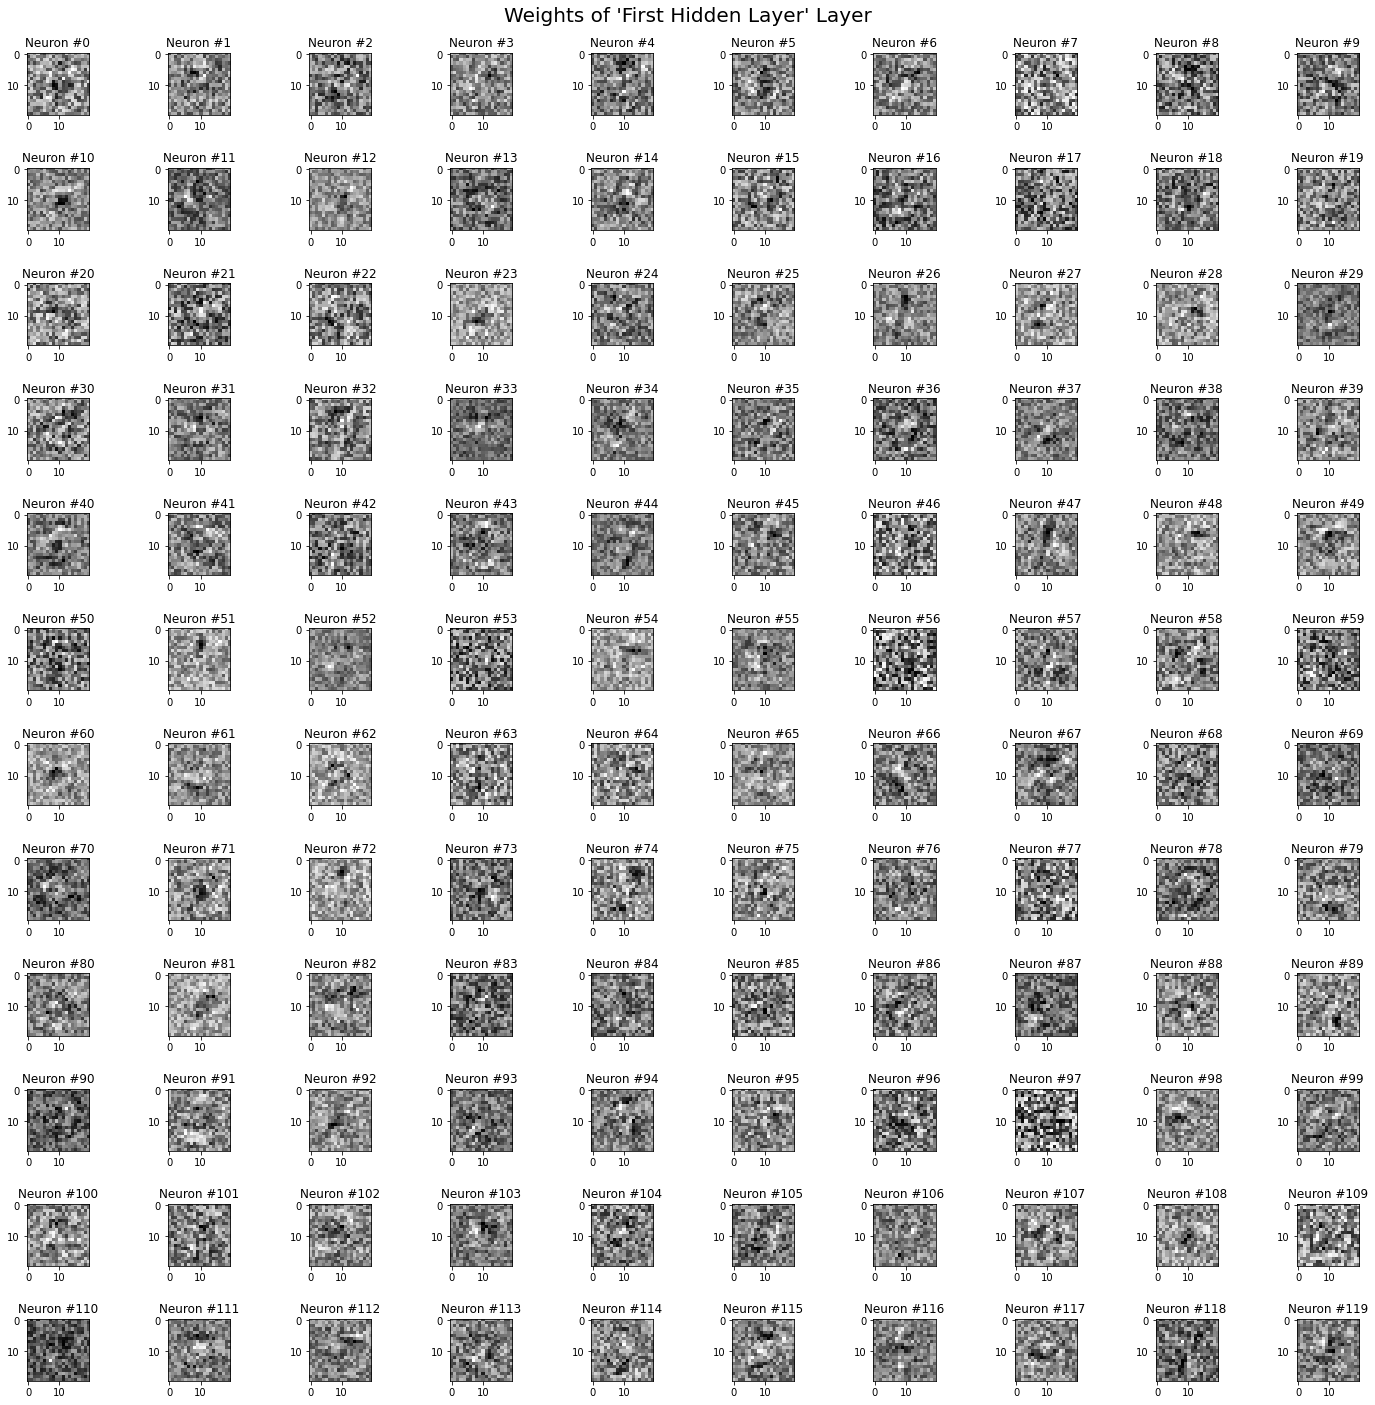

In [16]:
display_weights(model.weights[1][Model.w], (20, 20), True, "First Hidden Layer")

At any rate, our implementation is functional. It is unnecessary to implement a mini-batch/epoch-based neural network model, though it could surely increase performances.

We can now compare our model's performances to a model implemented using Tensorflow.

From what we can see on the performance of the model on our custom data, the model has trouble differentiating threes from eights threes from sevens, and eights from nines, which makes sense as those digits look quite similar.

The model mispredicts the custom one as well, probably because the one is too much on the left.

<img src="./custom_numbers/one.png" alt="Our custom one" style="width:200px;"/>

In [17]:
model = Sequential()

model.add(Flatten())
model.add(Dense(200, activation="relu", input_shape=(20*20, )))
model.add(Dense(50, activation="relu"))
model.add(Dense(10, activation="softmax"))
                
model.compile("sgd", "sparse_categorical_crossentropy")

train, test = Model.split_train_test(images, 0.8)

train_X = np.array(list(train[:, 0]), dtype=float).reshape(-1, 20*20)
train_expected = np.argmax(np.array(list(train[:, 1]), dtype=float), axis=1)

test_X = np.array(list(test[:, 0]), dtype=float).reshape(-1, 20*20)
test_expected = np.argmax(np.array(list(test[:, 1]), dtype=float), axis=1)

custom_X = np.array(list(custom[:, 0]), dtype=float).reshape(-1, 20*20)
custom_expected = np.argmax(np.array(list(custom[:, 1]), dtype=float), axis=1)

start_time = time.time()
model.fit(train_X, train_expected, batch_size=1, epochs=30)
print("Time taken: {0: .3f}s".format(time.time()-start_time))

print("Accuracy on train: {0:.2f}%".format(np.count_nonzero(np.argmax(model.predict(train_X), axis=1) == train_expected) / len(train_expected)))
print("Accuracy on test: {0:.2f}%".format(np.count_nonzero(np.argmax(model.predict(test_X), axis=1) == test_expected) / len(test_expected)))
print("Accuracy on custom: {0:.2f}%".format(np.count_nonzero(np.argmax(model.predict(custom_X), axis=1) == custom_expected) / len(custom_expected)))

print(np.argmax(model.predict(custom_X), axis=1))
print(custom_expected)

Epoch 1/30
4000/4000 [==============================] - 1s 337us/step - loss: 0.6206
Epoch 2/30
4000/4000 [==============================] - 1s 341us/step - loss: 0.2854
Epoch 3/30
4000/4000 [==============================] - 1s 335us/step - loss: 0.1918
Epoch 4/30
4000/4000 [==============================] - 1s 336us/step - loss: 0.1309
Epoch 5/30
4000/4000 [==============================] - 1s 333us/step - loss: 0.0919
Epoch 6/30
4000/4000 [==============================] - 1s 355us/step - loss: 0.0611
Epoch 7/30
4000/4000 [==============================] - 1s 341us/step - loss: 0.0430 
Epoch 8/30
4000/4000 [==============================] - 1s 336us/step - loss: 0.0280
Epoch 9/30
4000/4000 [==============================] - 1s 339us/step - loss: 0.0146
Epoch 10/30
4000/4000 [==============================] - 1s 351us/step - loss: 0.0115
Epoch 11/30
4000/4000 [==============================] - 1s 355us/step - loss: 0.0063
Epoch 12/30
4000/4000 [==============================] - 1s 36

In terms of overall performance, tensorflow's implementation is much more quick and optimized than our implementation from scratch. Otherwise, it yields almost the same results as our model.

# Second Example: Supervised Image Class Recognition


For fun, we can experiment with our model on the CIFAR-10 dataset, containing images from 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck).

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


TypeError: 'AxesSubplot' object is not subscriptable

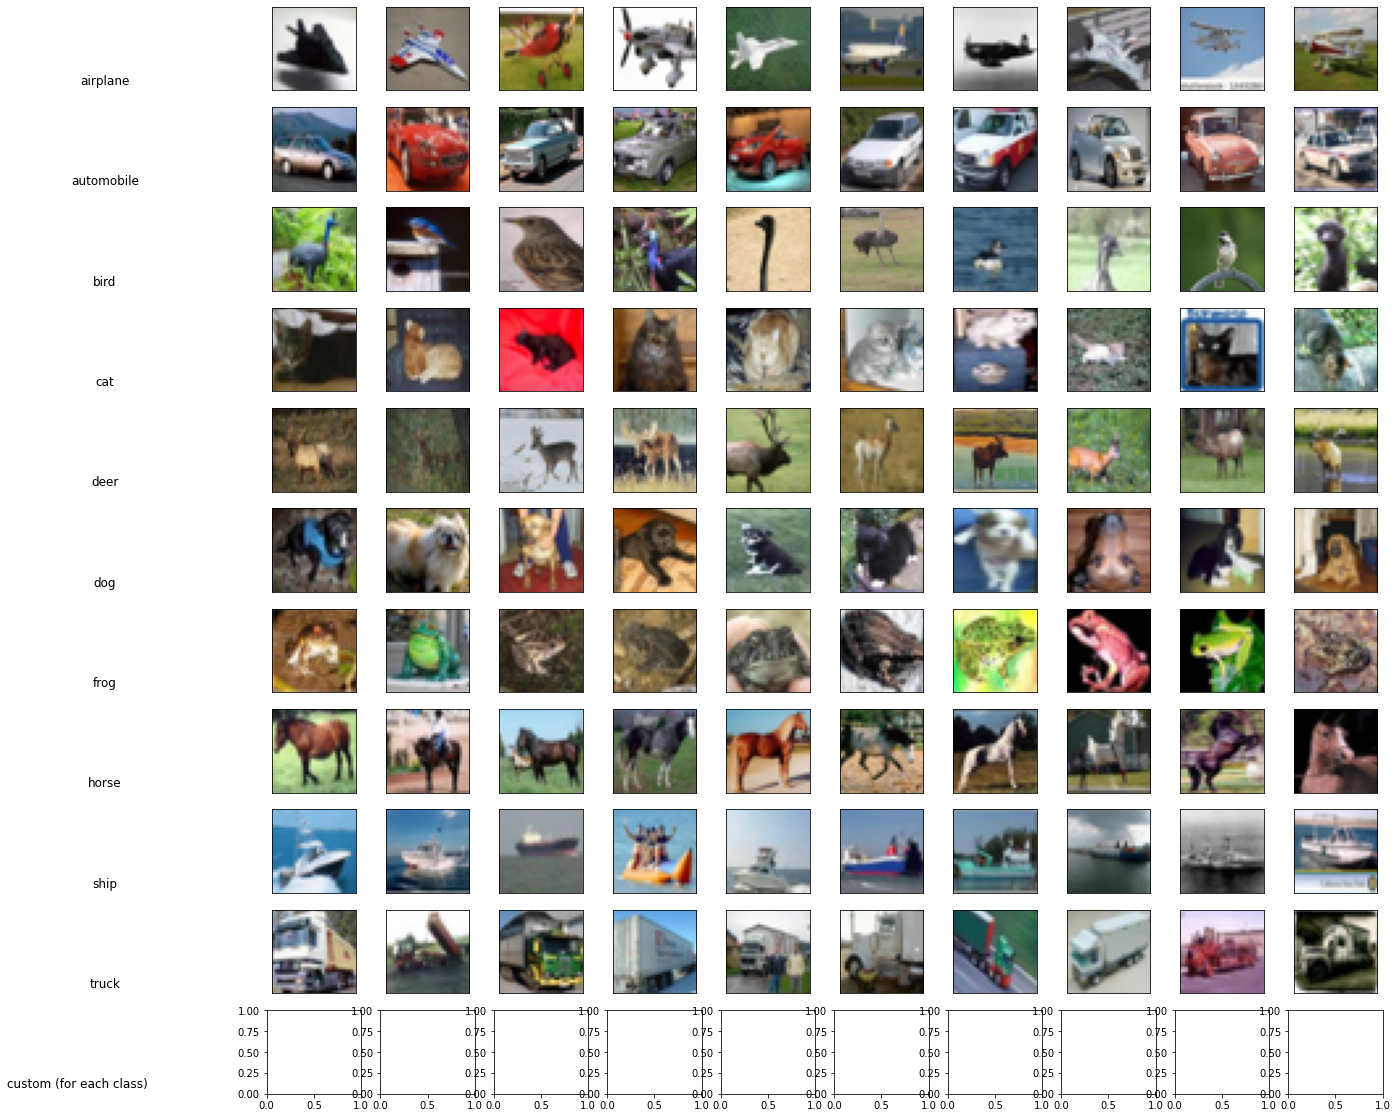

In [22]:
cifar = tf.keras.datasets.cifar10.load_data()

(x_train, y_train), (x_test, y_test) = cifar

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

one_hot_dict = {}

one_hot_train = np.zeros((y_train.shape[0], 10))
one_hot_test = np.zeros((y_test.shape[0], 10))

classes = "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
for i, cl in enumerate(classes):
    one_hot = np.zeros(10)
    one_hot[i] = 1
    one_hot_dict[cl] = one_hot

classes_examples = {cl: [] for cl in classes}

for i, (obs, label) in enumerate(zip(x_train, y_train)):
    n_class = label[0]

    one_hot = np.zeros(len(classes))
    one_hot[n_class] = 1
    one_hot_train[i] = np.array(one_hot)

    if len(classes_examples[classes[n_class]]) < 10:
        classes_examples[classes[n_class]].append(obs)

for i, (obs, label) in enumerate(zip(x_test, y_test)):
    n_class = label[0]

    one_hot = np.zeros(len(classes))
    one_hot[n_class] = 1
    one_hot_test[i] = np.array(one_hot)

fig, axes = plt.subplots(11, 10)
for i, line in enumerate(axes[:10]):
    line[0].set_title(classes[i], x=-2, y=0)
    for j, ax in enumerate(line):
        ax.imshow(classes_examples[classes[i]][j])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

custom_dict = {"airplane": 0, "automobile": 1, "bird": 2, "cat": 3, "deer": 4, "dog": 5, "frog": 6, "horse": 7, "ship": 8, "truck": 9}

x_custom = []
y_custom = []

for file, label in custom_dict.items():    
    img = Image.open("./custom_cifar/" + file + ".png")
    x_custom.append(np.array(img))
    y_custom.append(label)

last = axes[10]
last[0].set_title("custom (for each class)", x=-2, y=0)
for i in range(10):
    last[0][i].imshow(x_custom[i])
    
plt.show()
    
all_data = np.concatenate((x_train, x_test, x_custom))
min_data = np.amin(all_data)
max_data = np.amax(all_data)

    
x_custom = np.array(x_custom)
y_custom = np.array(y_custom)

x_train = ( x_train - min_data ) / ( max_data - min_data )
x_test = ( x_test - min_data ) / ( max_data - min_data )
x_custom = ( x_custom - min_data ) / ( max_data - min_data )


In [19]:
model_cifar = Model([FlattenLayer(32*32*3),
               DenseLayer(150, learning_rate=0.2),
               DenseLayer(70, learning_rate=0.2),
               DenseLayer(30, learning_rate=0.2),
               OutputLayer(10, gradient_of_cost_and_activation=Functions.Delta.log_loss_softmax,
                            learning_rate=0.15)])

data_train = np.array(list(zip(x_train, one_hot_train)))
data_test = np.array(list(zip(x_test, one_hot_test)))

model_cifar.train(data_train, 3, display_accuracy=True, data_test=data_test)

Epoch: 0, Total time Spent: 114.215s, Cost: 2.221
Cost per class:  [0.2186 0.2289 0.2318 0.2288 0.2237 0.2238 0.2186 0.2312 0.2046 0.2112]

Accuracy over test data: 0.17%



<ipython-input-5-d11373516e4e>:79: RuntimeWarning: overflow encountered in square
  return exp / ((exp + 1) ** 2)


Epoch: 1, Total time Spent: 221.148s, Cost: 2.172
Cost per class:  [0.2118 0.2256 0.2297 0.2259 0.2194 0.2182 0.2122 0.2296 0.1955 0.2039]

Accuracy over test data: 0.16%

Epoch: 2, Total time Spent: 326.927s, Cost: 2.163
Cost per class:  [0.2082 0.2254 0.2296 0.2262 0.2189 0.2182 0.2118 0.2285 0.1946 0.2014]

Accuracy over test data: 0.19%

Max iteration reached, ending main loop...



Without a minibatching implementation, our current implementation is way too slow to be useful Our model also tends to overflow because of the type we use, np.float64, which can overflow quickly as its integer part is bounded; to avoid this we could the type np.float128 (which would slow our model even more) or simply bound the outputs of our cost and activation functions

We might do a mini-batch model with overflow tolerance from sratch in a future project, but, for now, we will simply experiment with a Tensorflow model to predict the CIFAR dataset:

In [20]:
model_tf_cifar = Sequential()

print(one_hot_train.shape)

start = time.time()

model_tf_cifar.add(Flatten())
model_tf_cifar.add(Dense(200, activation="relu", input_shape=(32*32*3, )))
model_tf_cifar.add(Dense(50, activation="relu"))
model_tf_cifar.add(Dense(10, activation="softmax"))
                
model_tf_cifar.compile("sgd", "sparse_categorical_crossentropy")

model_tf_cifar.fit(x_train, y_train, batch_size=1, epochs=30)

custom_predicted = np.argmax(model_tf_cifar.predict(x_custom), axis=1)
print("Accuracy on train: {0:.2f}%".format(np.count_nonzero(np.argmax(model_tf_cifar.predict(x_train), axis=1) == y_train[:, 0]) / len(y_train)))
print("Accuracy on test: {0:.2f}%".format(np.count_nonzero(np.argmax(model_tf_cifar.predict(x_test), axis=1) == y_test[:, 0]) / len(y_test)))
print("Accuracy on custom: {0:.2f}%".format(np.count_nonzero(custom_predicted == y_custom) / len(y_custom)))

print(custom_predicted)
print(y_custom)

print("\nTotal time taken: %.2f seconds" % round(time.time()-start, 2))

(50000, 10)
Epoch 1/30
50000/50000 [==============================] - 42s 839us/step - loss: 1.9871
Epoch 2/30
50000/50000 [==============================] - 42s 836us/step - loss: 1.8901
Epoch 3/30
50000/50000 [==============================] - 42s 839us/step - loss: 1.8513
Epoch 4/30
50000/50000 [==============================] - 42s 837us/step - loss: 1.8284
Epoch 5/30
50000/50000 [==============================] - 41s 816us/step - loss: 1.8166
Epoch 6/30
50000/50000 [==============================] - 41s 825us/step - loss: 1.7964
Epoch 7/30
50000/50000 [==============================] - 41s 828us/step - loss: 1.7935
Epoch 8/30
50000/50000 [==============================] - 41s 828us/step - loss: 1.7837
Epoch 9/30
50000/50000 [==============================] - 41s 826us/step - loss: 1.7738
Epoch 10/30
50000/50000 [==============================] - 41s 827us/step - loss: 1.7603
Epoch 11/30
50000/50000 [==============================] - 41s 828us/step - loss: 1.7561
Epoch 12/30
50000/

The loss could be improved by a significant margin, but keeping with our single-observation batches means model training will take a very long time; we might showcase a more efficient model (with minibatchin) in a future project, as mentionned before